In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existin

Enter the path of the ECG image file: /content/drive/MyDrive/preprocessed_ECG_images/Abnormal heartbeat/HB(105).jpg


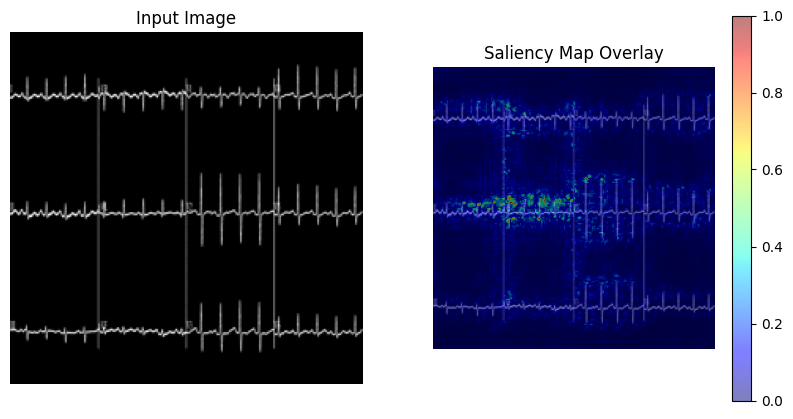

Predicted class: ECG Images of Patient that have History of MI
Confidence score: 0.4556


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the model path
model_path = "/content/drive/MyDrive/fused_model1"  # This should be a directory containing the model files

# Load the model
model = tf.saved_model.load(model_path)
predict_fn = model.signatures['serving_default']  # Adjust this if your serving function name is different

# Define preprocessing function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize to match model input size
    img_array = np.array(img) / 255.0  # Normalize
    return img_array

# Define the function to calculate saliency map and overlay it on the original image
def saliency(image_path, model):
    # Load and preprocess the image
    img = preprocess_image(image_path)

    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Add batch dimension

    # Compute gradients of the predicted class score w.r.t. input image
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = predict_fn(img_tensor)['dense']  # Use 'dense' based on your inspection
        predicted_class = tf.argmax(predictions[0])
        predicted_score = predictions[0][predicted_class]
    gradients = tape.gradient(predicted_score, img_tensor)

    # Calculate saliency map
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))

    # Plot the original image and the saliency map as a single plot
    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(img)
    plt.axis('off')

    # Plot the saliency map overlaying the original image
    plt.subplot(1, 2, 2)
    plt.title('Saliency Map Overlay')
    plt.imshow(img)
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)
    plt.colorbar()  # Overlay saliency map with transparency
    plt.axis('off')
    plt.savefig('saliency_map.png')
    plt.show()

    # Print the predicted class and confidence score
    class_labels = [
        'ECG Images of Patient that have History of MI',
        'ECG Images of Patient that have abnormal heartbeat',
        'ECG Images of MI',
        'Normal'
    ]
    predicted_class_index = tf.argmax(predictions[0]).numpy()
    predicted_class_label = class_labels[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index].numpy()

    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence score: {confidence_score:.4f}")

# Get the image path from user input
image_path = input("Enter the path of the ECG image file: ")

# Generate and display the saliency map overlaying the original image
saliency(image_path, model)


Enter the path of the ECG image file: /content/drive/MyDrive/preprocessed_ECG_images/MI Patients/MI(127).jpg


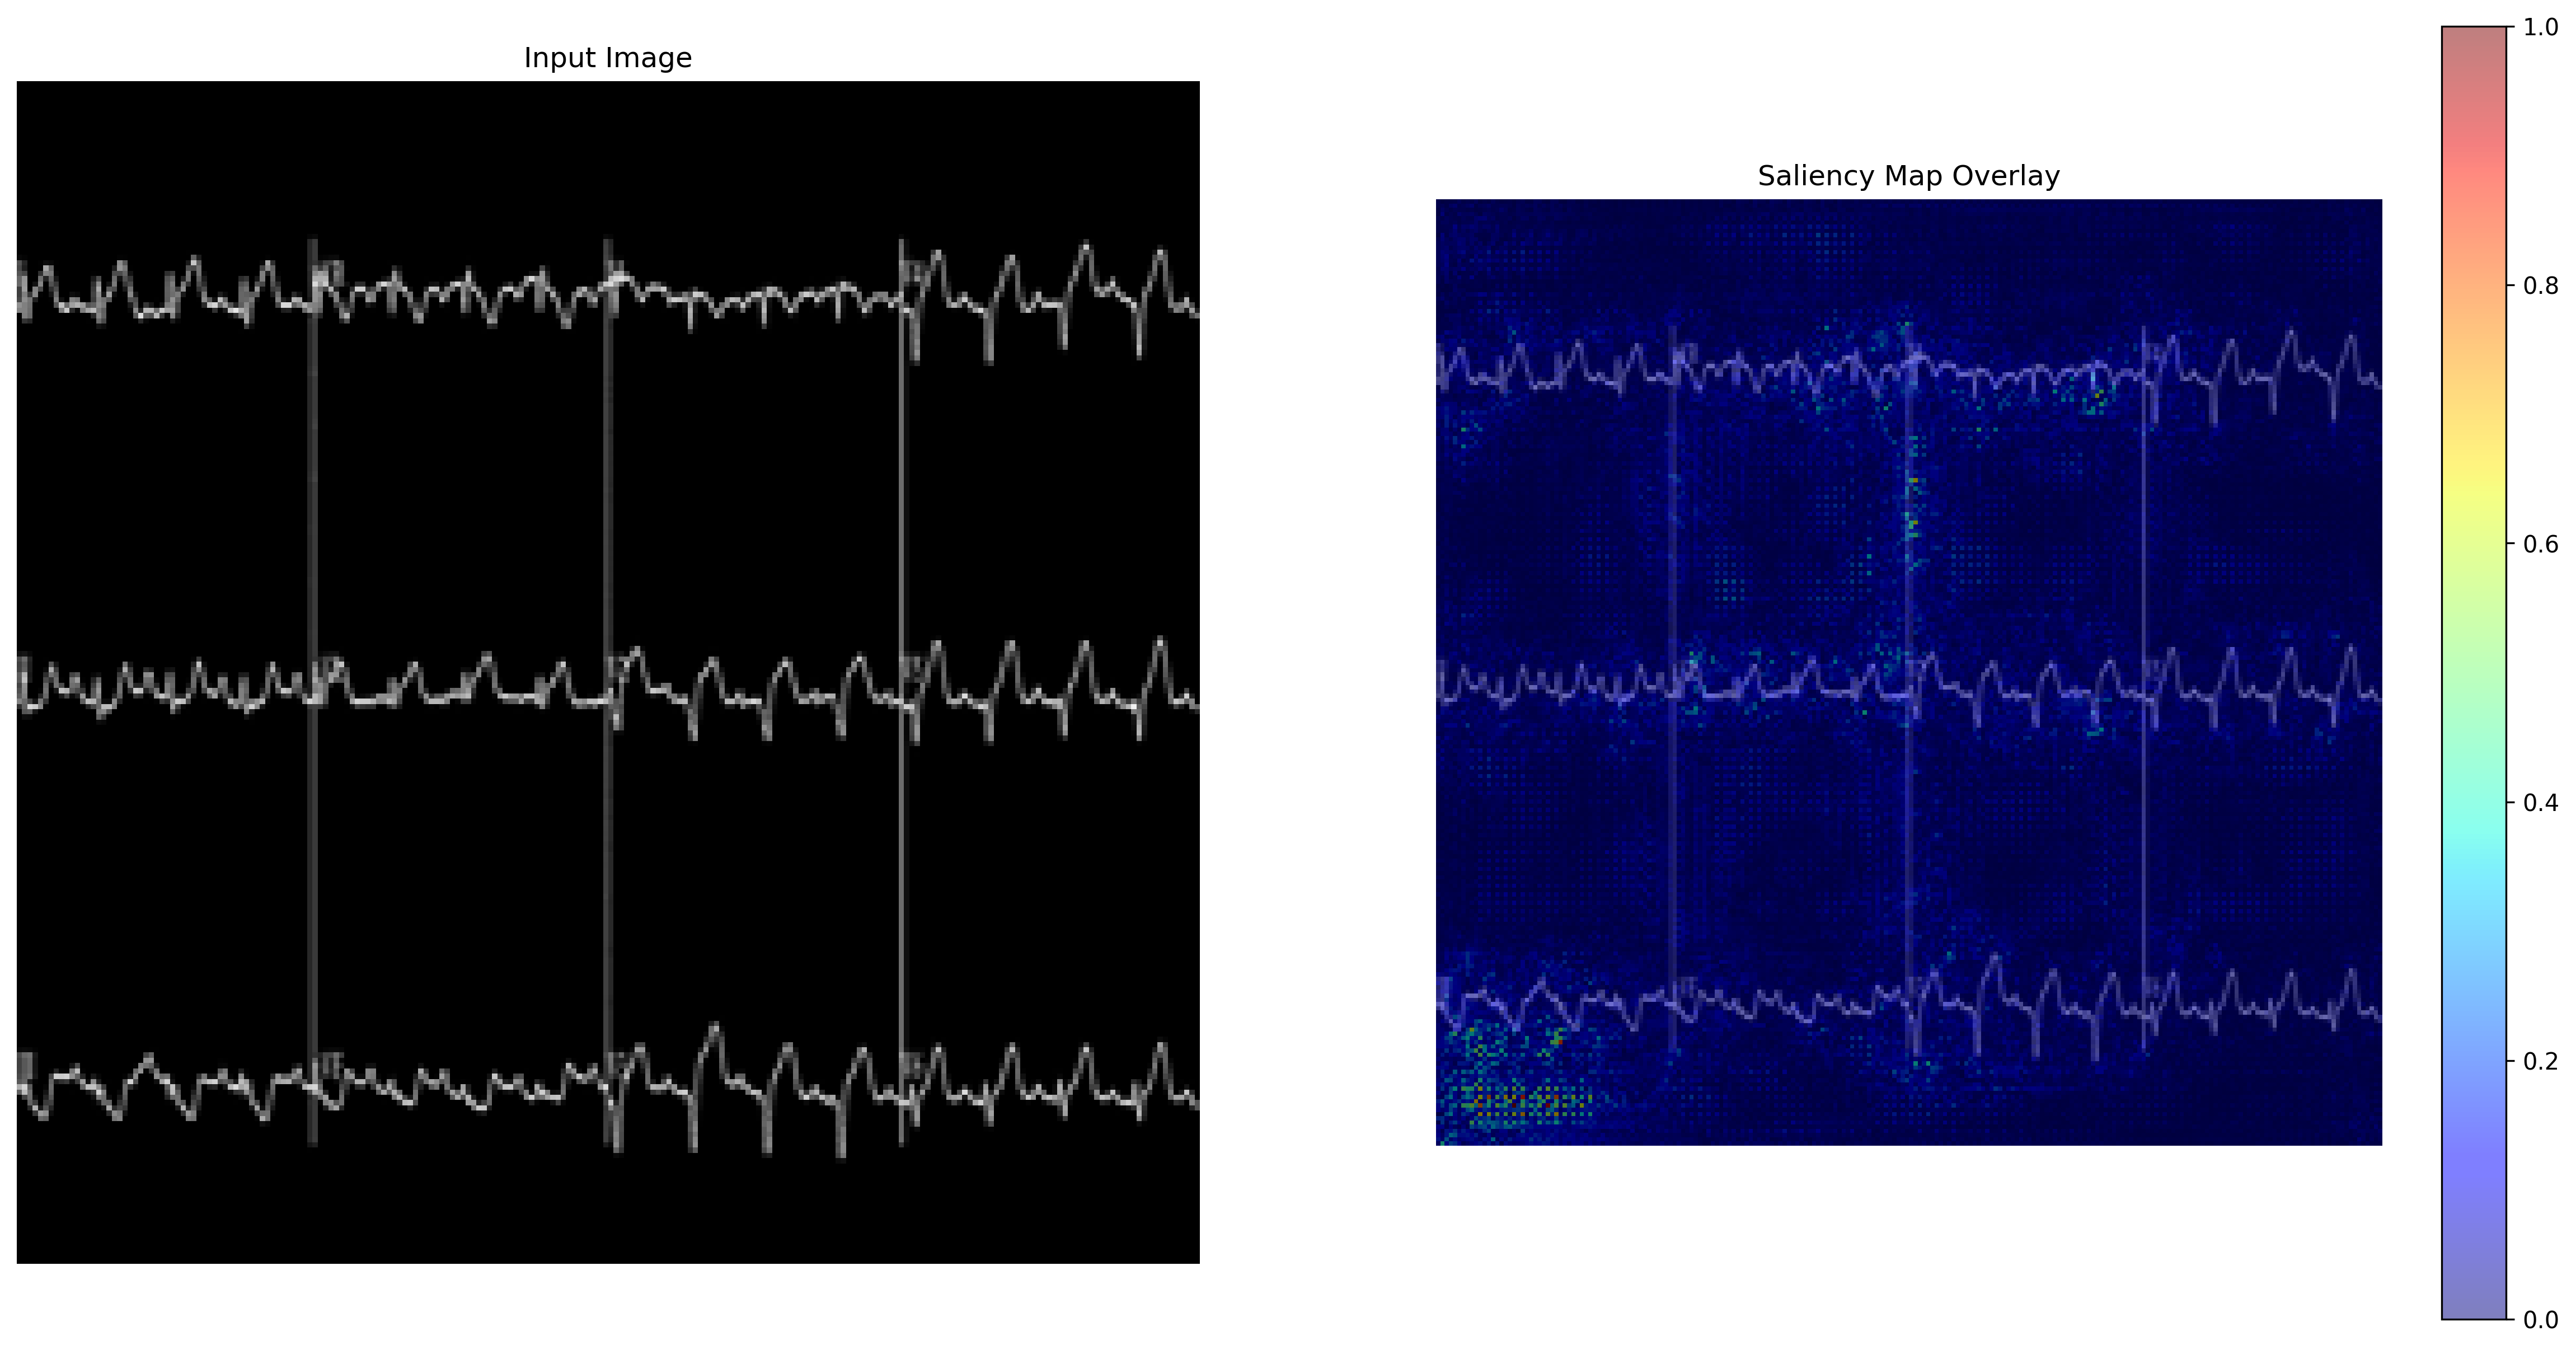

Predicted class: ECG Images of Patient that have History of MI
Confidence score: 0.4519


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the model path
model_path = "/content/drive/MyDrive/fused_model1"  # This should be a directory containing the model files

# Load the model
model = tf.saved_model.load(model_path)
predict_fn = model.signatures['serving_default']  # Adjust this if your serving function name is different

# Define preprocessing function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize to match model input size
    img_array = np.array(img) / 255.0  # Normalize
    return img_array

# Define the function to calculate saliency map and overlay it on the original image
def saliency(image_path, model):
    # Load and preprocess the image
    img = preprocess_image(image_path)

    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Add batch dimension

    # Compute gradients of the predicted class score w.r.t. input image
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = predict_fn(img_tensor)['dense']  # Use 'dense' based on your inspection
        predicted_class = tf.argmax(predictions[0])
        predicted_score = predictions[0][predicted_class]
    gradients = tape.gradient(predicted_score, img_tensor)

    # Calculate saliency map
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))

    # Increase clarity by setting the DPI
    dpi = 300  # Higher DPI for better clarity

    # Plot the original image and the saliency map as a single plot
    plt.figure(figsize=(20, 10), dpi=dpi)

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(img)
    plt.axis('off')

    # Plot the saliency map overlaying the original image
    plt.subplot(1, 2, 2)
    plt.title('Saliency Map Overlay')
    plt.imshow(img)
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)
    plt.colorbar()  # Overlay saliency map with transparency
    plt.axis('off')

    # Save the figure as a PDF with high resolution
    plt.savefig('saliency_map.pdf', format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()

    # Print the predicted class and confidence score
    class_labels = [
        'ECG Images of Patient that have History of MI',
        'ECG Images of Patient that have abnormal heartbeat',
        'ECG Images of MI',
        'Normal'
    ]
    predicted_class_index = tf.argmax(predictions[0]).numpy()
    predicted_class_label = class_labels[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index].numpy()

    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence score: {confidence_score:.4f}")

# Get the image path from user input
image_path = input("Enter the path of the ECG image file: ")

# Generate and display the saliency map overlaying the original image
saliency(image_path, model)


Enter the path of the ECG image file: /content/drive/MyDrive/preprocessed_ECG_images/History of MI/PMI(99).jpg


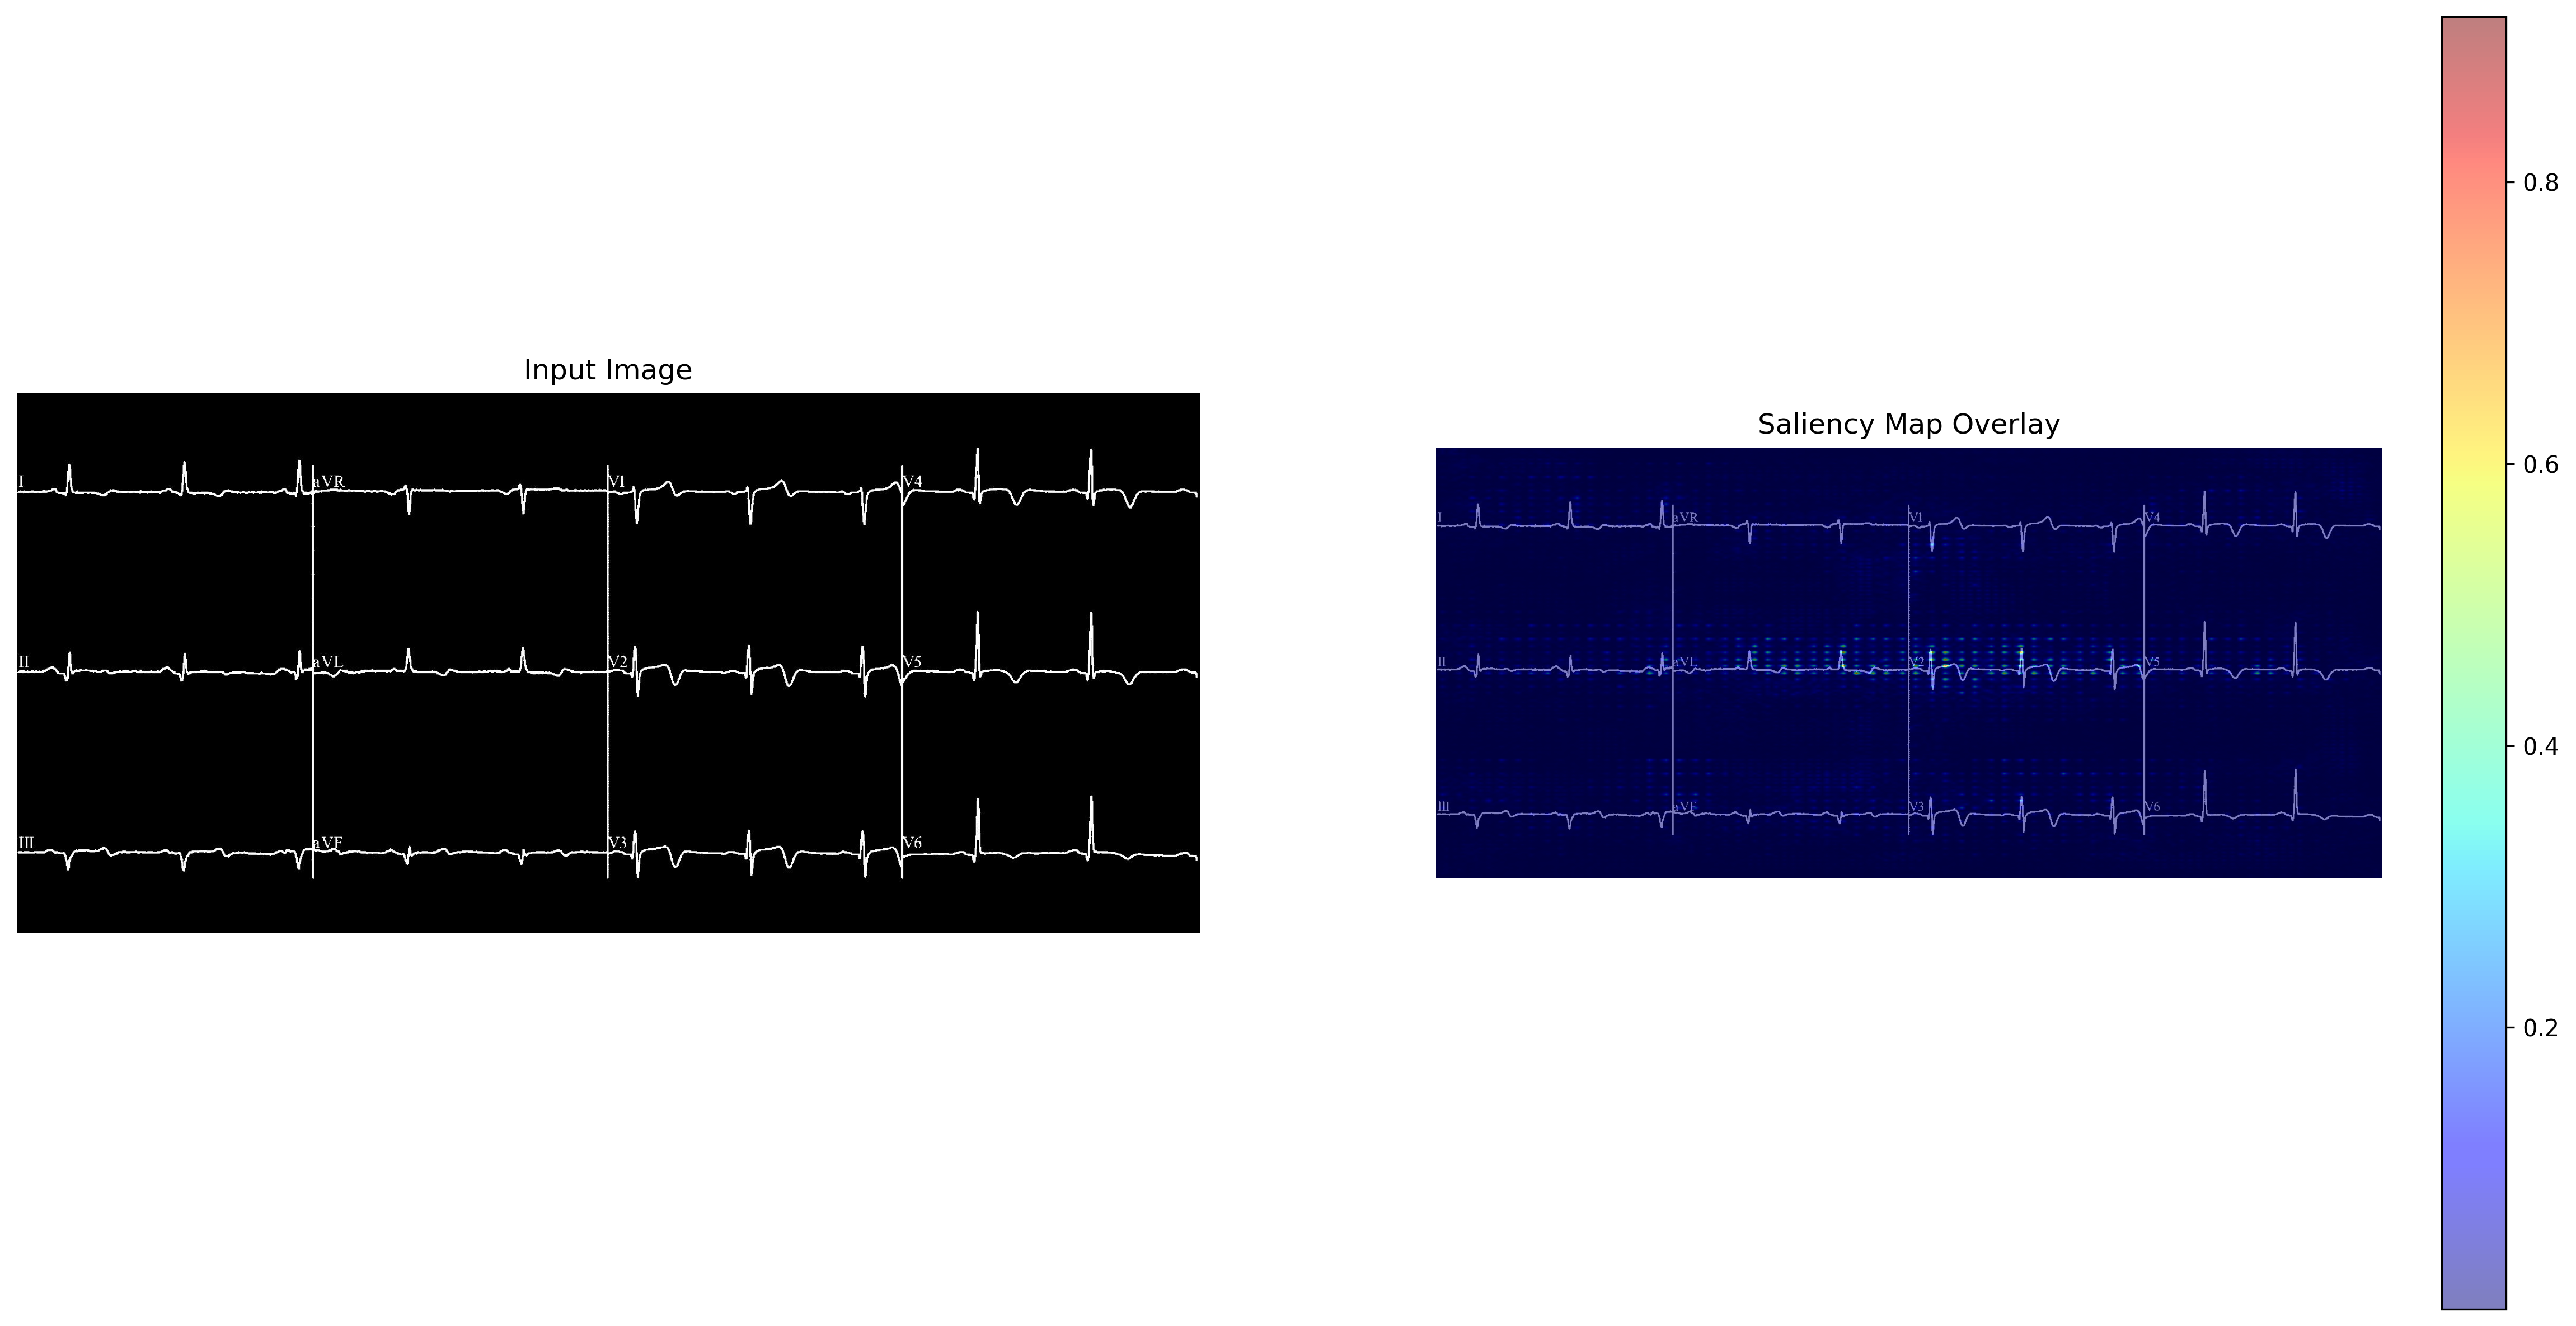

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the model path
model_path = "/content/drive/MyDrive/fused_model1"  # This should be a directory containing the model files

# Load the model
model = tf.saved_model.load(model_path)
predict_fn = model.signatures['serving_default']  # Adjust this if your serving function name is different

# Define preprocessing function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img_resized = img.resize((224, 224))  # Resize to match model input size
    img_array = np.array(img_resized) / 255.0  # Normalize
    return img, img_array, img.size

# Define the function to calculate saliency map and overlay it on the original image
def saliency(image_path, model):
    # Load and preprocess the image
    original_img, img_array, original_size = preprocess_image(image_path)
    original_width, original_height = original_size  # Original image dimensions

    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Add batch dimension

    # Compute gradients of the predicted class score w.r.t. input image
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = predict_fn(img_tensor)['dense']  # Use 'dense' based on your inspection
        predicted_class = tf.argmax(predictions[0])
        predicted_score = predictions[0][predicted_class]
    gradients = tape.gradient(predicted_score, img_tensor)

    # Calculate saliency map
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))

    # Resize the saliency map to the original image size
    saliency_map_resized = tf.image.resize(saliency_map[..., tf.newaxis], size=[original_height, original_width], method='bilinear')
    saliency_map_resized = tf.squeeze(saliency_map_resized)  # Remove singleton dimension

    # Convert saliency map to a numpy array
    saliency_map_resized = saliency_map_resized.numpy()

    # Increase clarity by setting the DPI
    dpi = 300  # Higher DPI for better clarity

    # Plot the original image and the saliency map as a single plot
    plt.figure(figsize=(20, 10), dpi=dpi)

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(original_img)
    plt.axis('off')

    # Plot the saliency map overlaying the original image
    plt.subplot(1, 2, 2)
    plt.title('Saliency Map Overlay')
    plt.imshow(original_img)
    plt.imshow(saliency_map_resized, cmap='jet', alpha=0.5)
    plt.colorbar()  # Overlay saliency map with transparency
    plt.axis('off')

    # Save the figure as a PDF with high resolution
    plt.savefig('saliency_map.pdf', format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()

    # Print the predicted class and confidence score
    class_labels = [
        'ECG Images of Patient that have History of MI',
        'ECG Images of Patient that have abnormal heartbeat',
        'ECG Images of MI',
        'Normal'
    ]
    predicted_class_index = tf.argmax(predictions[0]).numpy()
    predicted_class_label = class_labels[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index].numpy()

    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence score: {confidence_score:.4f}")

# Get the image path from user input
image_path = input("Enter the path of the ECG image file: ")

# Generate and display the saliency map overlaying the original image
saliency(image_path, model)


Enter the path of the ECG image file: /content/drive/MyDrive/preprocessed_ECG_images/MI Patients/MI(10).jpg


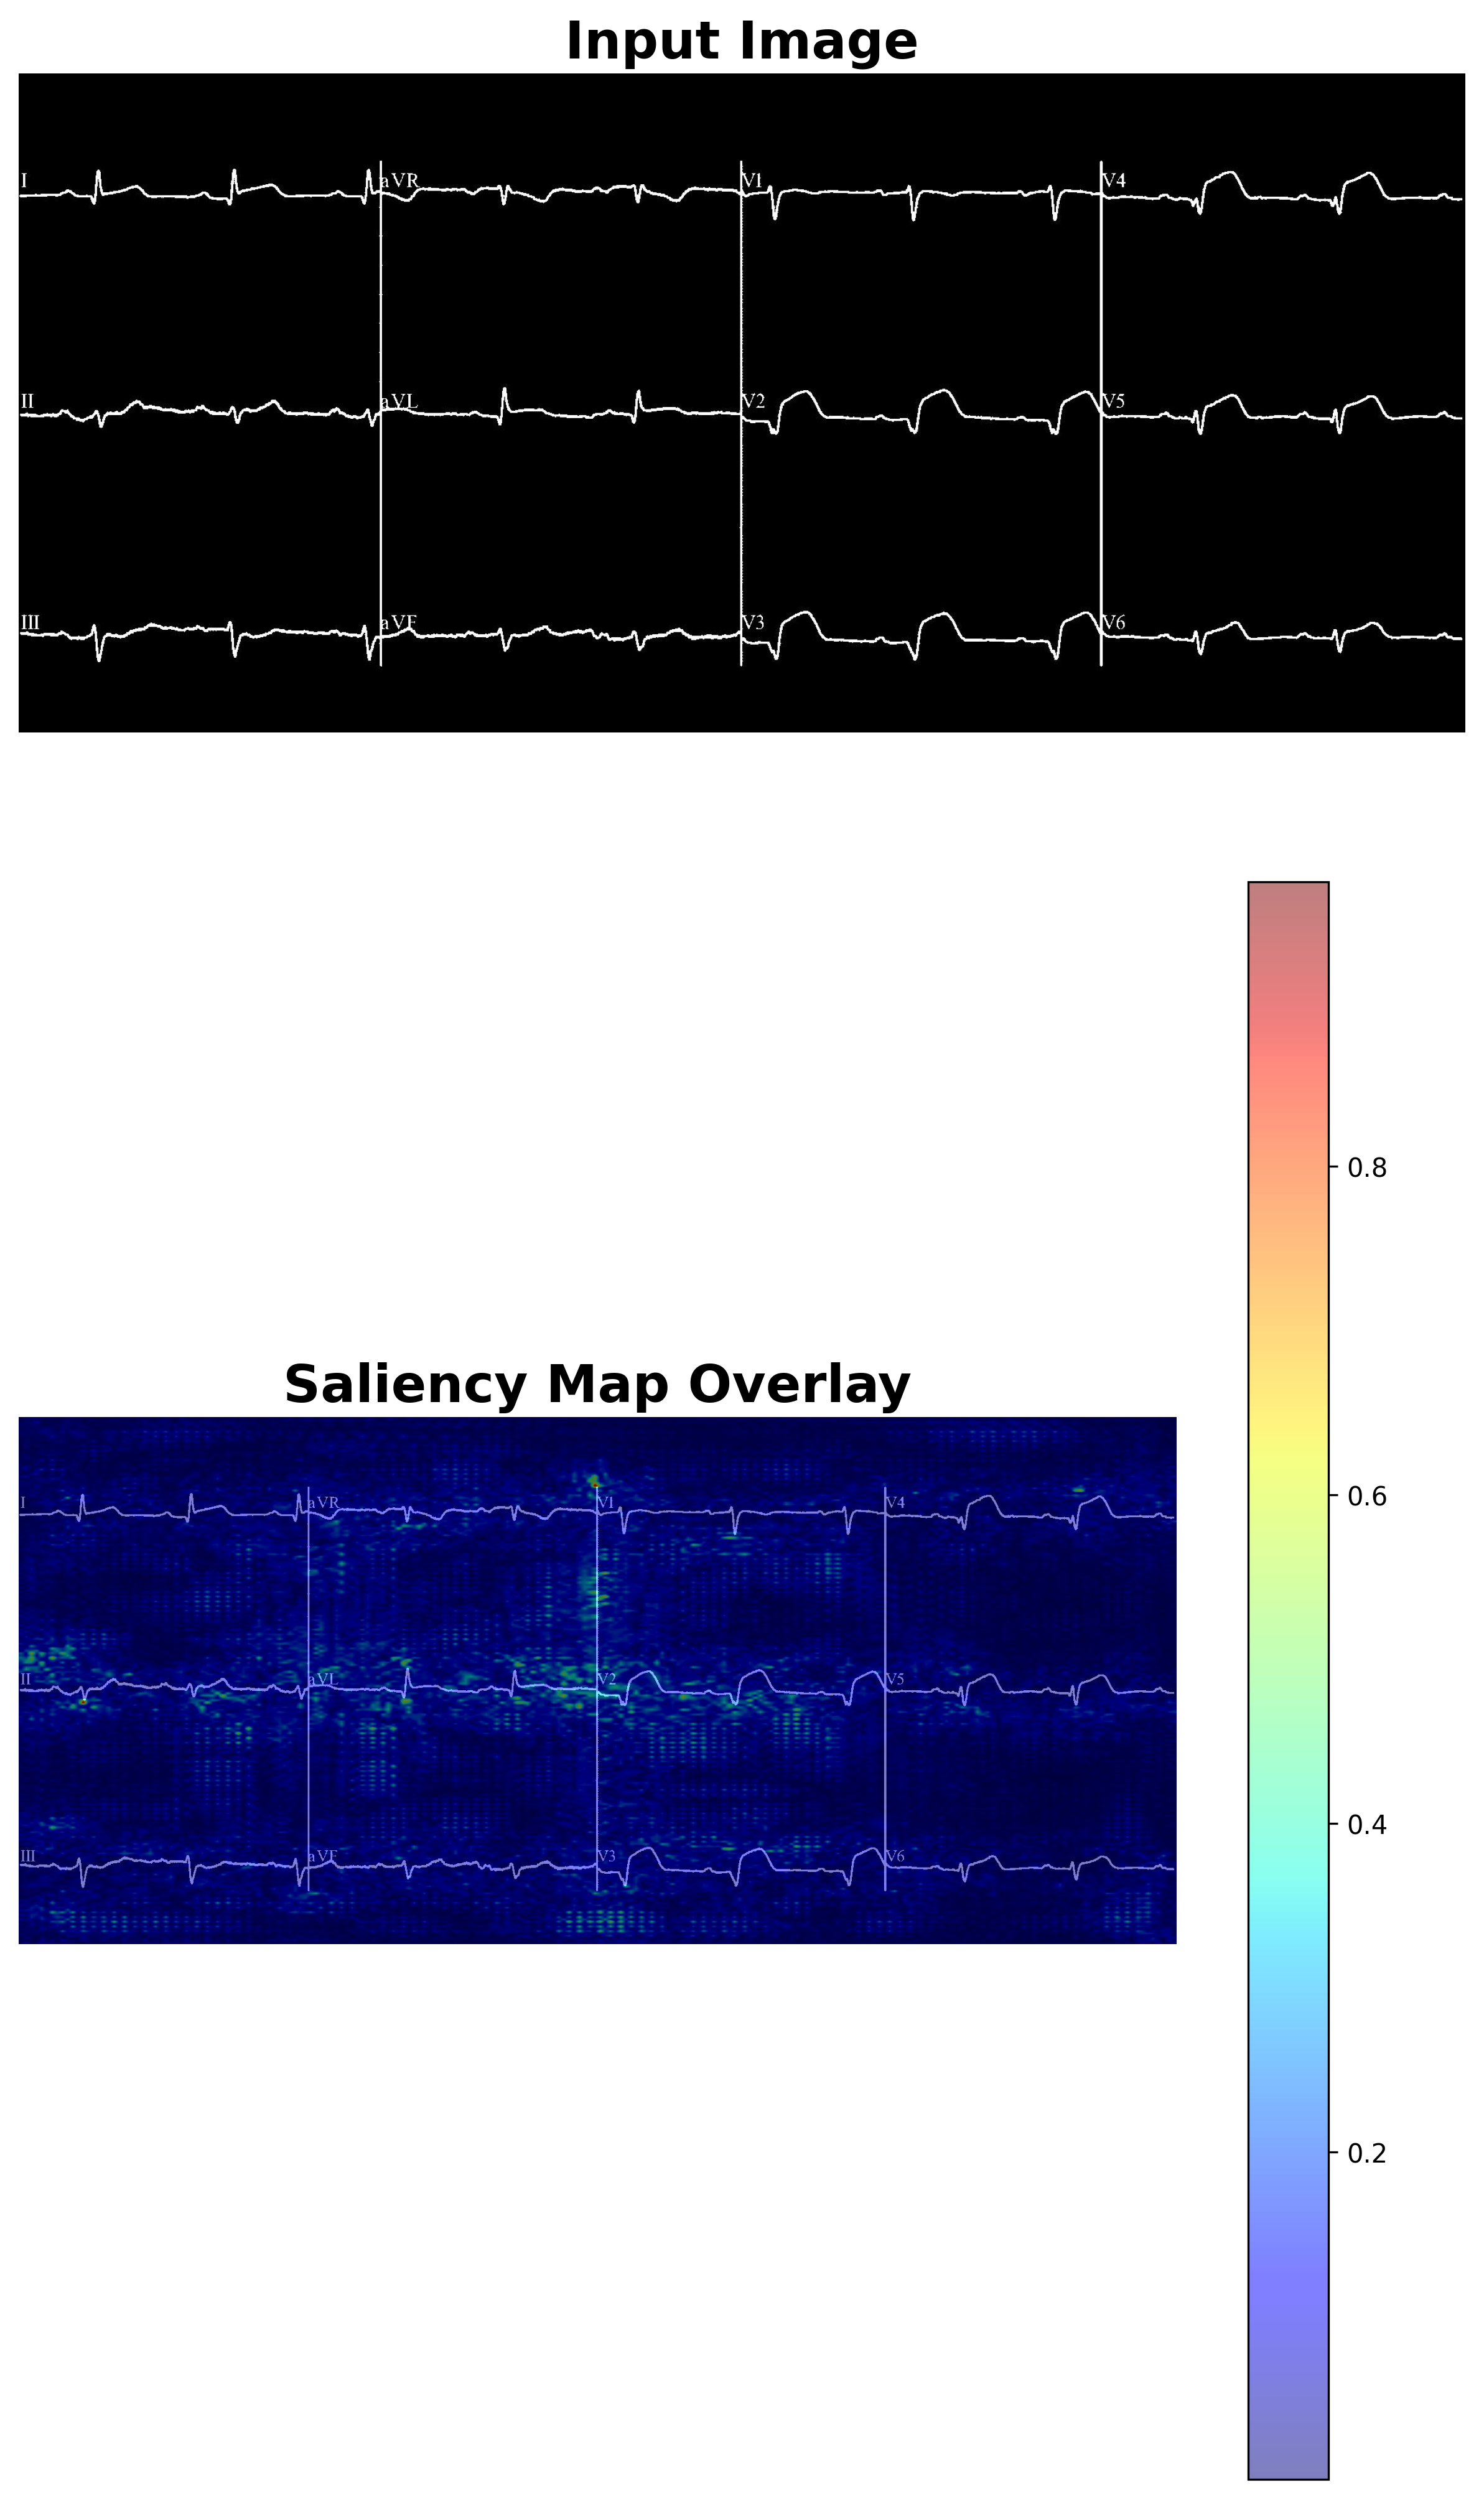

Predicted class: ECG Images of MI
Confidence score: 0.6163


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the model path
model_path = "/content/drive/MyDrive/fused_model1"  # This should be a directory containing the model files

# Load the model
model = tf.saved_model.load(model_path)
predict_fn = model.signatures['serving_default']  # Adjust this if your serving function name is different

# Define preprocessing function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img_resized = img.resize((224, 224))  # Resize to match model input size
    img_array = np.array(img_resized) / 255.0  # Normalize
    return img, img_array, img.size

# Define the function to calculate saliency map and overlay it on the original image
def saliency(image_path, model):
    # Load and preprocess the image
    original_img, img_array, original_size = preprocess_image(image_path)
    original_width, original_height = original_size  # Original image dimensions

    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Add batch dimension

    # Compute gradients of the predicted class score w.r.t. input image
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = predict_fn(img_tensor)['dense']  # Use 'dense' based on your inspection
        predicted_class = tf.argmax(predictions[0])
        predicted_score = predictions[0][predicted_class]
    gradients = tape.gradient(predicted_score, img_tensor)

    # Calculate saliency map
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))

    # Resize the saliency map to the original image size
    saliency_map_resized = tf.image.resize(saliency_map[..., tf.newaxis], size=[original_height, original_width], method='bilinear')
    saliency_map_resized = tf.squeeze(saliency_map_resized)  # Remove singleton dimension

    # Convert saliency map to a numpy array
    saliency_map_resized = saliency_map_resized.numpy()

    # Increase clarity by setting the DPI
    dpi = 300  # Higher DPI for better clarity

    # Plot the original image and the saliency map as a vertical stack
    plt.figure(figsize=(10, 20), dpi=dpi)

    # Plot the original image
    plt.subplot(2, 1, 1)
    plt.title('Input Image', fontsize=20, fontweight='bold')
    plt.imshow(original_img)
    plt.axis('off')

    # Plot the saliency map overlaying the original image
    plt.subplot(2, 1, 2)
    plt.title('Saliency Map Overlay', fontsize=20, fontweight='bold')
    plt.imshow(original_img)
    plt.imshow(saliency_map_resized, cmap='jet', alpha=0.5)
    plt.colorbar()  # Overlay saliency map with transparency
    plt.axis('off')

    # Adjust space between plots
    plt.subplots_adjust(hspace=-0.2)  # Reduce the space between the subplots

    # Save the figure as a PDF with high resolution
    plt.savefig('saliency_map.pdf', format='pdf', dpi=dpi, bbox_inches='tight')
    plt.savefig('saliency_map.png', format='png', dpi=dpi, bbox_inches='tight')
    plt.show()

    # Print the predicted class and confidence score
    class_labels = [
        'ECG Images of Patient that have History of MI',
        'ECG Images of Patient that have abnormal heartbeat',
        'ECG Images of MI',
        'Normal'
    ]
    predicted_class_index = tf.argmax(predictions[0]).numpy()
    predicted_class_label = class_labels[predicted_class_index]
    confidence_score = predictions[0][predicted_class_index].numpy()

    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence score: {confidence_score:.4f}")

# Get the image path from user input
image_path = input("Enter the path of the ECG image file: ")

# Generate and display the saliency map overlaying the original image
saliency(image_path, model)


Enter the path of the ECG image file: /content/drive/MyDrive/preprocessed_ECG_images/MI Patients/MI(10).jpg


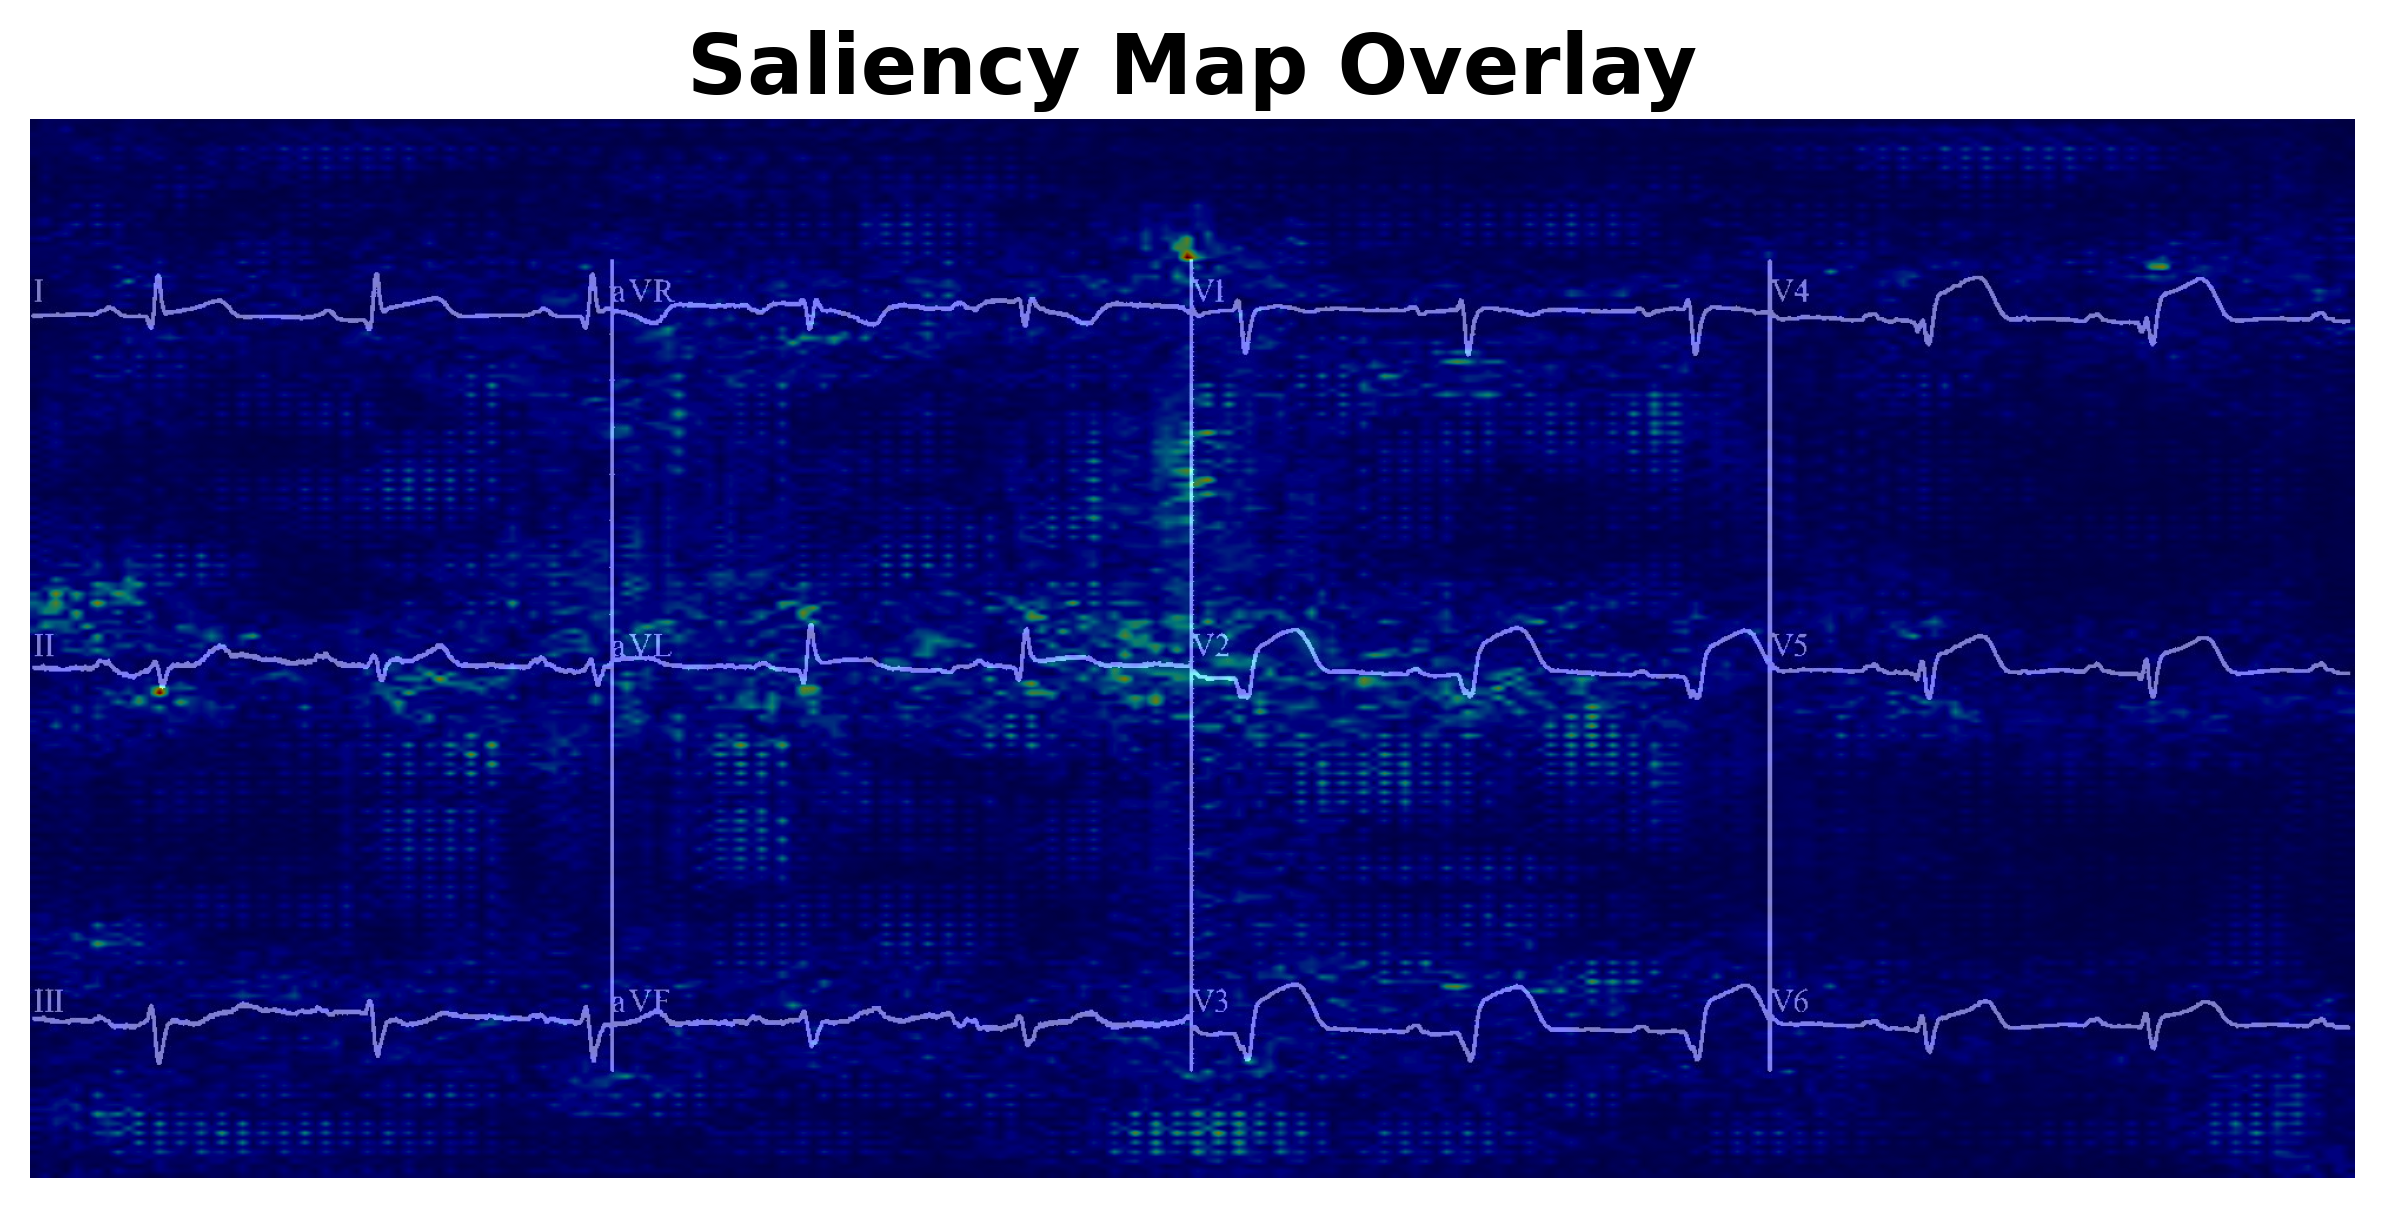

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

# Define the model path
model_path = "/content/drive/MyDrive/fused_model1"  # Adjust the path to your model

# Load the model
model = tf.saved_model.load(model_path)
predict_fn = model.signatures['serving_default']  # Adjust this if your serving function name is different

# Define preprocessing function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img_resized = img.resize((224, 224))  # Resize to match model input size
    img_array = np.array(img_resized) / 255.0  # Normalize
    return img, img_array, img.size

# Define the function to calculate and overlay the saliency map
def saliency(image_path, model):
    # Load and preprocess the image
    original_img, img_array, original_size = preprocess_image(image_path)
    original_width, original_height = original_size  # Original image dimensions

    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)  # Add batch dimension

    # Compute gradients of the predicted class score w.r.t. input image
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = predict_fn(img_tensor)['dense']  # Use 'dense' based on your model's output layer
        predicted_class = tf.argmax(predictions[0])
        predicted_score = predictions[0][predicted_class]
    gradients = tape.gradient(predicted_score, img_tensor)

    # Calculate saliency map
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]
    saliency_map = (saliency_map - tf.reduce_min(saliency_map)) / (tf.reduce_max(saliency_map) - tf.reduce_min(saliency_map))

    # Resize the saliency map to the original image size
    saliency_map_resized = tf.image.resize(saliency_map[..., tf.newaxis], size=[original_height, original_width], method='bilinear')
    saliency_map_resized = tf.squeeze(saliency_map_resized)  # Remove singleton dimension

    # Convert saliency map to a numpy array
    saliency_map_resized = saliency_map_resized.numpy()

    # Increase clarity by setting the DPI
    dpi = 300  # Higher DPI for better clarity

    # Plot the saliency map overlaying the original image
    plt.figure(figsize=(10, 10), dpi=dpi)
    plt.title('Saliency Map Overlay', fontsize=20, fontweight='bold')
    plt.imshow(original_img)
    plt.imshow(saliency_map_resized, cmap='jet', alpha=0.5)
    plt.axis('off')

    # Save the figure as a PDF with high resolution
    plt.savefig('saliency_map_overlay.pdf', format='pdf', dpi=dpi, bbox_inches='tight')
    plt.savefig('saliency_map_overlay.png', format='png', dpi=dpi, bbox_inches='tight')
    plt.show()

# Get the image path from user input
image_path = input("Enter the path of the ECG image file: ")

# Generate and display the saliency map overlaying the original image
saliency(image_path, model)


In [ ]:
from google.colab import files
files.download('saliency_map_overlay.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>